In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy as sp
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import  MultiTaskLasso, Lasso
from sklearn.metrics import pairwise_distances_argmin_min
from tqdm import tqdm
import random
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path="/Users/Manita/OneDrive - NOVAIMS/machine learning/Project_02/data/alcohol_children.xlsx"
df=pd.read_excel(data_path, index_col=0)

In [3]:
from sklearn.model_selection import train_test_split 
seed = 0
test_size = 0.1
target = 'alcopops'
df, df_test = train_test_split(df, test_size=test_size, random_state=seed)


In [4]:
print('Train Nr. obs:\t{}'.format(df.shape[0]))
print('Test Nr. obs:\t{}'.format(df_test.shape[0]))

Train Nr. obs:	219
Test Nr. obs:	25


In [5]:
#df_numeric = df.select_dtypes(include=['number'])
df.drop(columns = ['country','code'], inplace=True)
df.dropna(inplace = True)

In [6]:
import random

def generate_artificial(centroids_df, df_to_clust, percent, scaler,seed):
    random.seed(seed)
    columns = centroids_df.columns.values
    columns = np.append(columns, 'cluster')
    artificial_points = pd.DataFrame(columns = columns)
    
    for j in range(len(centroids_df)):
    
        rows = int(len(df_to_clust.loc[df_to_clust['cluster_labels'] == j])*percent)

        for x in range(rows):

            list1 = centroids_df.iloc[j].values
            list2 = df_to_clust.loc[df_to_clust['cluster_labels'] == j].iloc[x]
            point = []
            for i in range(len(list1)):             
                point.append(random.uniform(list1[i], list2[i]))
            point.append(j)
            artificial_points.loc[len(artificial_points)] = point

        artificial_points['cluster'] = artificial_points['cluster'].astype(int)
        
        variables = ['gender', 'year_collect']

        for variable in variables:
            counter = 0
            while counter < len(centroids_df):
                mode = stats.mode(df_to_clust.loc[df_to_clust['cluster_labels'] == counter, variable].values)[0]
                artificial_points.loc[artificial_points['cluster'] == counter, variable] = mode
                counter +=1

        artificial_points['gender'] = artificial_points['gender'].astype(int)

    df_to_clust.drop(columns = 'cluster_labels',inplace=True)
    artificial_points.drop(columns = 'cluster',inplace=True)
    
    reverse_scaling = pd.DataFrame(scaler.inverse_transform(artificial_points),
                                   columns = artificial_points.columns,
                                   index = artificial_points.index)
        
    
    artificial_df = artificial_points.drop(columns = 'alcopops')

    artificial_df = pd.concat([reverse_scaling['alcopops'],artificial_df], axis = 1)
    
        
    return artificial_df

In [7]:
def get_artificial_df(n_clusters, df, percent ,seed):
    
    df_to_clust = df.copy()
    scaler = MinMaxScaler()
    df_to_clust = scaler.fit_transform(df_to_clust)
    df_to_clust=pd.DataFrame(df_to_clust, columns =  df.columns)
    
    cluster_range = range(1,n_clusters+1)
    cluster_errors = []
    sse = {}
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, 
                    random_state=seed,
                    n_init = 10,
                    max_iter = 300).fit(df_to_clust)
        sse[k] = kmeans.inertia_
        cluster_errors.append(kmeans.inertia_)

    df_to_clust["cluster_labels"] = kmeans.labels_
    centroids_df = pd.DataFrame(kmeans.cluster_centers_,columns=df_to_clust.drop(columns = ['cluster_labels']).columns)
    
    artificial_df = generate_artificial(centroids_df, df_to_clust, percent, scaler ,seed)
    
    
    return artificial_df

In [27]:
def artificial_concat(scaled_df, artificial_df):
    return pd.concat([scaled_df,artificial_df], axis = 0)

In [33]:
# Scale original data
scaler = MinMaxScaler()
x = scaler.fit_transform(df.drop(columns = target))
x = pd.DataFrame(x, columns = df.drop(columns = target).columns, index = df.drop(columns = target).index)
y = df[target]

scaled_df = pd.concat([y, x], axis = 1)

In [39]:
artificial_vs_original = {'original': scaled_df.copy(),
                          'art_5c_80prop':artificial_concat(scaled_df, get_artificial_df(5, df, 0.8, seed)),
                          'art_10c_80prop':artificial_concat(scaled_df, get_artificial_df(10, df, 0.8, seed)),
                          'art_15c_80prop':artificial_concat(scaled_df, get_artificial_df(15, df, 0.8, seed)),
                          'art_5c_50prop':artificial_concat(scaled_df, get_artificial_df(5, df, 0.5, seed)),
                          'art_10c_50prop':artificial_concat(scaled_df, get_artificial_df(10, df, 0.5, seed)),
                          'art_15c_50prop':artificial_concat(scaled_df, get_artificial_df(15, df, 0.5, seed))}

In [41]:
CV = 100
entries = []
l=pd.DataFrame()

for key, df_ in artificial_vs_original.items():
    x_train = df_.drop(columns = target)
    y_train = df_[target]

    accuracies = cross_val_score(LinearRegression(), x_train, y_train, scoring='neg_mean_squared_error', cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((key, fold_idx, accuracy))

In [52]:
df_pred = pd.DataFrame(entries, columns=['df', 'fold_idx', 'error'])
df_pred_grouped = pd.DataFrame(df_pred.groupby('df')['error'].agg('mean'))
df_pred_grouped.sort_values(by = 'error', ascending = False, inplace = True)
df_pred_grouped

,error
df,
art_5c_80prop,-3.926744
art_15c_80prop,-4.016251
art_5c_50prop,-4.223810
art_10c_80prop,-4.251780
art_15c_50prop,-4.325935
art_10c_50prop,-4.530949
original,-5.935921


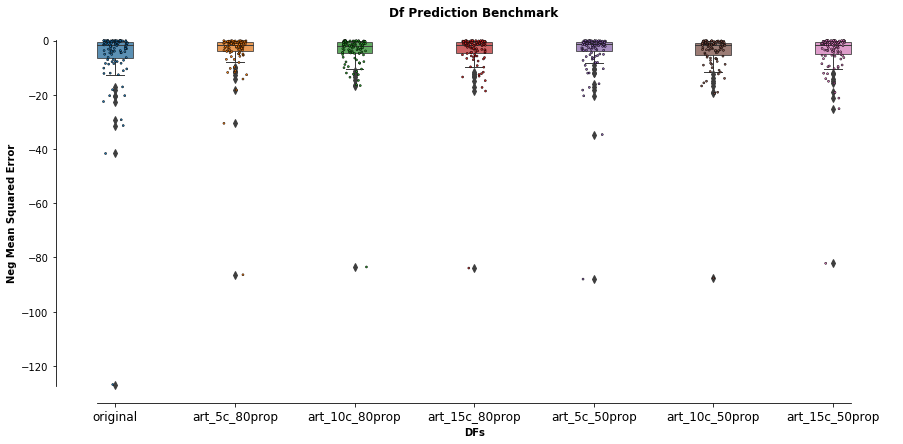

In [53]:
plt.figure(figsize = (15,7))
ax = sns.boxplot(x='df', y='error', data=df_pred,boxprops=dict(alpha=.8),linewidth=1, width = 0.3)
sns.stripplot(x='df', y='error', data=df_pred, 
              size=2, jitter=True, edgecolor="black", linewidth=.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, fontsize =12) 
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
plt.title('Df Prediction Benchmark',  fontweight = "bold")
plt.xlabel('DFs',  fontweight = "bold")
plt.ylabel('Neg Mean Squared Error',  fontweight = "bold")
plt.show()